In [1]:
dataset_name = "ambient_temperature_system_failure"
path = "data/" + dataset_name + ".csv"
gaussian_window_size = 1024

In [2]:
import adclasses
import pandas as pd
import matplotlib.pyplot as plt
import holidays
import joblib
import numpy as np
import math
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Preprocess dataset

In [3]:
data = pd.read_csv(path, header=0)
start_date = data["timestamp"].values[0]
end_date = data["timestamp"].values[-1]
print("Start date: ", start_date)
print("End date: ", end_date)
data["timestamp"] = pd.to_datetime(data["timestamp"], format="%Y-%m-%d %H:%M:%S")

print("Missing time stamps: \n", adclasses.find_missing_time_steps(start_date, end_date, '1H', data))

# if you want to use a method that cannot take missing time steps
# into account, you need to fill in the missing time steps yourself
# this function also removes duplicates
print("Fill Missing Time Steps with Interpolation")
data = adclasses.fill_missing_time_steps(start_date, end_date, '1H', data, method="linear")

# write to csv for htm
# data.to_csv("/home/cfreeman/Desktop/prefill/" + dataset_name + ".csv", index=False)

data["timestamp"] = pd.to_datetime(data["timestamp"], format="%Y-%m-%d %H:%M:%S")
ad = adclasses.UnivariateAnomalyDetection(dataframe=data, timestep="1H", dateformat="%Y-%m-%d %H:%M:%S", name=dataset_name)
print("Length: ", ad.get_length())
print("Time step size: ", ad.get_timestep())
print("Date Format: ", ad.get_dateformat())
true_outlier_dates = ["2013-12-22 20:00:00",
                      "2014-04-13 09:00:00"]
true_outlier_indices = ad.convert_true_outlier_date(true_outlier_dates)
print("True outlier indices: ", true_outlier_indices)

Start date:  2013-07-04 00:00:00
End date:  2014-05-28 15:00:00
Missing time stamps: 
 DatetimeIndex(['2013-07-28 02:00:00', '2013-07-28 05:00:00',
               '2013-07-28 06:00:00', '2013-07-28 07:00:00',
               '2013-07-28 08:00:00', '2013-07-28 09:00:00',
               '2013-07-28 10:00:00', '2013-07-28 11:00:00',
               '2013-07-28 12:00:00', '2013-07-28 13:00:00',
               ...
               '2014-04-10 05:00:00', '2014-04-10 06:00:00',
               '2014-04-10 07:00:00', '2014-04-10 08:00:00',
               '2014-04-10 09:00:00', '2014-04-10 10:00:00',
               '2014-04-10 11:00:00', '2014-04-10 12:00:00',
               '2014-04-10 13:00:00', '2014-04-10 14:00:00'],
              dtype='datetime64[ns]', length=621, freq=None)
Fill Missing Time Steps with Interpolation
Length:  7888
Time step size:  1H
Date Format:  %Y-%m-%d %H:%M:%S
True outlier indices:  [4124, 6801]


# windowed gaussian

In [4]:
# optimization step
step_sizes = [100, 200, 300, 400, 500]

opt_dict = {}

for step_size in step_sizes:
    print("Step size: ", step_size)
    output_dict = ad.windowed_gaussian(gaussian_window_size=gaussian_window_size, 
                                       step_size = step_size, 
                                       optimize=True,
                                       plot_anomaly_score=False)
    print("MSE: ", output_dict["MSE"])
    opt_dict[step_size] = output_dict["MSE"]

best_step_size = min(opt_dict, key=opt_dict.get)
print("\nbest step size: ", best_step_size)

Step size:  100
MSE:  13.089687128331235
Step size:  200
MSE:  13.081536441968561
Step size:  300
MSE:  13.081536441968561
Step size:  400
MSE:  13.081536441968561
Step size:  500
MSE:  13.081536441968561

best step size:  200


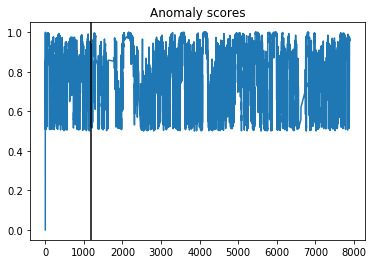

Time:  0.20361661911010742


['anomaly_scores/windowed_gaussian/ambient_temperature_system_failure']

In [5]:
save_path = "anomaly_scores/windowed_gaussian/" + dataset_name

output_dict = ad.windowed_gaussian(gaussian_window_size=gaussian_window_size, 
                                   step_size = best_step_size, 
                                   plot_anomaly_score=True)

print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# SARIMA: using autoarima


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : 3048.054
 Regression with ARIMA(0,1,0) errors : 3241.263
 Regression with ARIMA(1,1,0) errors : 3075.162
 Regression with ARIMA(0,1,1) errors : 3067.453
 ARIMA(0,1,0)                    : 3239.149
 Regression with ARIMA(1,1,2) errors : 3054.739
 Regression with ARIMA(2,1,1) errors : 3059.217
 Regression with ARIMA(3,1,2) errors : 3051.036
 Regression with ARIMA(2,1,3) errors : 3050.153
 Regression with ARIMA(1,1,1) errors : 3061.294
 Regression with ARIMA(1,1,3) errors : 3050.668
 Regression with ARIMA(3,1,1) errors : 3057.611
 Regression with ARIMA(3,1,3) errors : 3053.199
 ARIMA(2,1,2)                    : 3045.892
 ARIMA(1,1,2)                    : 3052.621
 ARIMA(2,1,1)                    : 3057.115
 ARIMA(3,1,2)                    : 3048.757
 ARIMA(2,1,3)                    : 3048.016
 ARIMA(1,1,1)                    : 3059.135
 ARIMA(1,1,3)                    : 3048.558
 ARIMA(3,1,

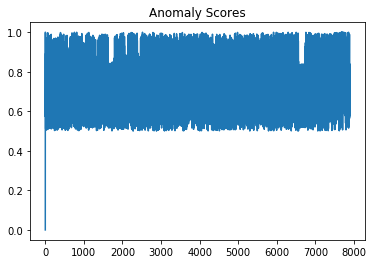

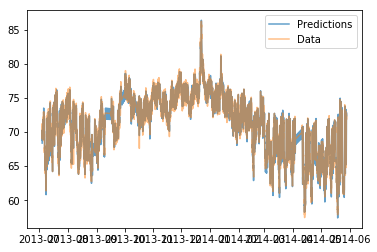

Time:  51.5011260509491


['anomaly_scores/SARIMA_auto/ambient_temperature_system_failure']

In [6]:
save_path = "anomaly_scores/SARIMA_auto/" + dataset_name
output_dict = ad.sarimax(gaussian_window_size=gaussian_window_size, step_size=100, auto=True,
                         use_exog=True, s=24, plot_anomaly_scores=True,plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# FB Prophet

In [7]:
# optimization step

step_sizes = [100, 200]
seasonality_prior_scales = [1, 5, 10, 15, 20]
seasonality_modes = ["additive", "multiplicative"]
changepoint_prior_scales = [.01, .05, .1, .15, .2]
opt_dict = {}

for step_size in step_sizes:
    for seasonality_prior_scale in seasonality_prior_scales:
        for seasonality_mode in seasonality_modes:
            for changepoint_prior_scale in changepoint_prior_scales:
                
                mse = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                          daily_seasonality=True, 
                                          seasonality_prior_scale=seasonality_prior_scale,
                                          seasonality_mode=seasonality_mode,
                                          changepoint_prior_scale=changepoint_prior_scale,
                                          step_size=step_size,
                                          optimize=True)
                print("Step Size: ", step_size)
                print("Seasonality Prior Scale: ", seasonality_prior_scale)
                print("Seasonality Mode: ", seasonality_mode)
                print("Changepoint Prior Scale: ", changepoint_prior_scale)
                print("MSE: ",mse)
                
                key_str = "Step Size " + str(step_size) + " Seasonality Prior Scale " + str(seasonality_prior_scale) +" Seasonality Mode " + str(seasonality_mode) +" Changepoint Prior Scale" + str(changepoint_prior_scale)
                
                opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  3.5183387416939036


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  3.4143183252025784


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  3.4435479650556813


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  3.447890993721403


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  3.4423160353211926


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  3.6863020214936766


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  3.5569753648917737


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  3.596554838924818


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  3.612867200377565


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  3.6138279007702345


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  3.5338131845603016


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  3.40708586706435


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  3.4426755175558275


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  3.4543300687996705


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  3.444887762056006


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  3.639024820182502


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  3.590496315467033


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  3.622479997652234


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  3.6179135234256314


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  3.600750260369312


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  3.519211499641816


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  3.4144044302639958


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  3.427834533298497


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  3.4373626429539694


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  3.462220834362684


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  3.699374166327828


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  3.569946471693265


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  3.591928384519753


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  3.602046501004185


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  3.6062442907017243


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  3.4724762754053127


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  3.3990050348622134


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  3.4286438377192794


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  3.4424193572860657


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  3.4563181538739625


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  3.7076417315479224


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  3.5836271388186947


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  3.593083678549258


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  3.6188361800264843


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  3.6153778055829977


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  3.494711804576294


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  3.42385319497989


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  3.423267131958224


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  3.451171437406418


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  3.4529176845777023


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  3.6853417471193493


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  3.562753763508708


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  3.6593735525887996


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  3.624985518572471


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  3.613386966773724


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  3.5183387416939036


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  3.4143183252025784


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  3.4435479650556813


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  3.447890993721403


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  3.4423160353211926


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  3.6863020214936766


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  3.5569753648917737


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  3.596554838924818


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  3.612867200377565


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  3.6138279007702345


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  3.5338131845603016


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  3.40708586706435


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  3.4426755175558275


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  3.4543300687996705


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  3.444887762056006


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  3.639024820182502


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  3.590496315467033


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  3.622479997652234


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  3.6179135234256314


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  3.600750260369312


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  3.519211499641816


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  3.4144044302639958


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  3.427834533298497


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  3.4373626429539694


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  3.462220834362684


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  3.699374166327828


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  3.569946471693265


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  3.591928384519753


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  3.602046501004185


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  3.6062442907017243


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  3.4724762754053127


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  3.3990050348622134


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  3.4286438377192794


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  3.4424193572860657


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  3.4563181538739625


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  3.7076417315479224


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  3.5836271388186947


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  3.593083678549258


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  3.6188361800264843


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  3.6153778055829977


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  3.494711804576294


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  3.42385319497989


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  3.423267131958224


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  3.451171437406418


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  3.4529176845777023


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  3.6853417471193493


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  3.562753763508708


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  3.6593735525887996


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  3.624985518572471
Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  3.613386966773724

best params:  Step Size 100 Seasonality Prior Scale 15 Seasonality Mode additive Changepoint Prior Scale0.05


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


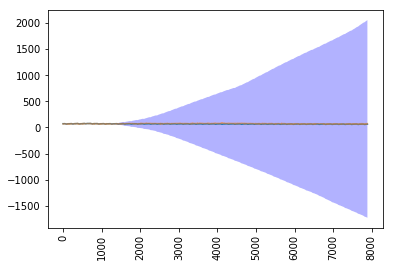

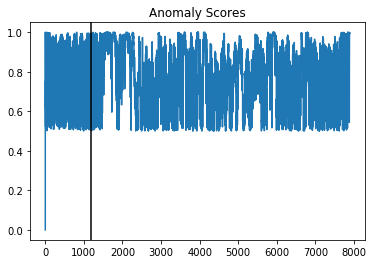

Time:  26.924574613571167


['anomaly_scores/Prophet/ambient_temperature_system_failure']

In [8]:
save_path = "anomaly_scores/Prophet/" + dataset_name
output_dict = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                  daily_seasonality=True, 
                                  seasonality_prior_scale=15,
                                  seasonality_mode="additive",
                                  changepoint_prior_scale=.05,
                                  step_size=100,
                                  plot_forecast=True,
                                  plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# Twitter AD

In [9]:
# only need one window size

# save_path = "anomaly_scores/Twitter/" + dataset_name
# output_dict = ad.twitterad(period=24, max_anoms=((.2/100) * ad.get_length())/ad.get_length(), direction='both', alpha=.001, plot_anomaly_score=True)
# print("Time: ", output_dict["Time"])
# joblib.dump(output_dict, save_path)

# HTM

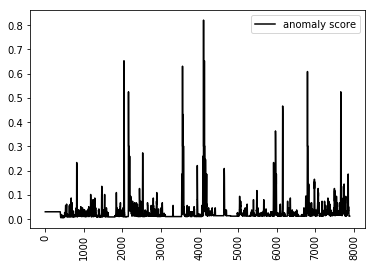

Time:  91


['anomaly_scores/HTM/ambient_temperature_system_failure']

In [10]:
htm_results_path = "htm_studio_results/" + "htm_results_" + dataset_name + "_value.csv"

htm_results = pd.read_csv(htm_results_path, header=0)

plt.plot(htm_results["raw_anomaly_score"], color="black", label="anomaly score")
plt.legend()
plt.xticks(rotation=90)
plt.show()

anomaly_scores = np.nan_to_num(htm_results["raw_anomaly_score"].values)

save_path = "anomaly_scores/HTM/" + dataset_name
print("Time: ", 91)
output_dict = {"Anomaly Scores": anomaly_scores, "Time": 91}
joblib.dump(output_dict, save_path)

# STL Resid

In [11]:
# optimization step
swindows = ["periodic", 5,7,9,11]
sdegrees = [0,1,2]
twindows = [5,7,9,11]
tdegrees = [0,1,2]
inners = [1,2,3]
outers = [0,1]
opt_dict = {}

for swindow in swindows:
    for sdegree in sdegrees:
        for twindow in twindows:
            for tdegree in tdegrees:
                for inner in inners:
                    for outer in outers:
                        
                        print("swindow: ", swindow)
                        print("sdegree: ", sdegree)
                        print("twindow: ", twindow)
                        print("tdegree: ", tdegree)
                        print("inner: ", inner)
                        print("outer: ", outer)
                        
                        
                        try:
  
                            stl_resid_sum = ad.stl_resid(gaussian_window_size=gaussian_window_size, step_size=100,n_periods=24, swindow=swindow, 
                                                         sdegree=sdegree, twindow=twindow, tdegree=tdegree, inner=inner, 
                                                         outer=outer, fill_option="linear", optimize=True)


                            print("STL Resid Sum: ",stl_resid_sum)

                            key_str = "swindow " + str(swindow) + " sdegree " + str(sdegree) +" twindow " + str(twindow) +" tdegree " + str(tdegree) +" inner " + str(inner) +" outer " + str(outer)

                            opt_dict[key_str] = stl_resid_sum

                        except:
                            print("Fail")
                            continue

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  230.44250242893443
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  230.46834739510544
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  230.43509110580445
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  230.44250242893443
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  230.43231605152351
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  230.43751808624768
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  1
inn

R stlplus completed: 1183 no missing True
STL Resid Sum:  265.1036430211853
swindow:  periodic
sdegree:  0
twindow:  9
tdegree:  2
inner:  3
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  265.1135661777516
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  410.05854352354123
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  410.104550211237
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  410.05772595325664
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  410.05854352354123
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  3
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum: 

R stlplus completed: 1183 no missing True
STL Resid Sum:  192.08359424610285
swindow:  periodic
sdegree:  1
twindow:  7
tdegree:  2
inner:  3
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  192.06258172709815
swindow:  periodic
sdegree:  1
twindow:  7
tdegree:  2
inner:  3
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  192.0759921735878
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  1
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  370.34944623433677
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  1
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  370.3804237492326
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  370.349620905181
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  370.

R stlplus completed: 1183 no missing True
STL Resid Sum:  0.3731823079653585
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  2
inner:  2
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  0.38613146086635597
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  2
inner:  3
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  0.36066741276633185
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  2
inner:  3
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  0.3796016724728012
swindow:  periodic
sdegree:  2
twindow:  7
tdegree:  0
inner:  1
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  318.6123575399795
swindow:  periodic
sdegree:  2
twindow:  7
tdegree:  0
inner:  1
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  318.641239417303
swindow:  periodic
sdegree:  2
twindow:  7
tdegree:  0
inner:  2
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  3

R stlplus completed: 1183 no missing True
STL Resid Sum:  310.84771705286676
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  2
inner:  2
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  310.82397091960286
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  2
inner:  2
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  310.8259798437387
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  2
inner:  3
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  310.82240596483746
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  2
inner:  3
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  310.82483339503153
swindow:  5
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  113.47678420602762
swindow:  5
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  112.1239985

R stlplus completed: 1183 no missing True
STL Resid Sum:  128.3617410867335
swindow:  5
sdegree:  0
twindow:  9
tdegree:  2
inner:  2
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  127.66606701269164
swindow:  5
sdegree:  0
twindow:  9
tdegree:  2
inner:  3
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  128.4484175315781
swindow:  5
sdegree:  0
twindow:  9
tdegree:  2
inner:  3
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  128.21409372895522
swindow:  5
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  190.50970748023428
swindow:  5
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  188.66346847257773
swindow:  5
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  192.0973843460664
swindow:  5
sdegree:  0

R stlplus completed: 1183 no missing True
STL Resid Sum:  93.03627681739995
swindow:  5
sdegree:  1
twindow:  7
tdegree:  2
inner:  3
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  93.80074082971555
swindow:  5
sdegree:  1
twindow:  7
tdegree:  2
inner:  3
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  93.62158508444087
swindow:  5
sdegree:  1
twindow:  9
tdegree:  0
inner:  1
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  169.26431283821154
swindow:  5
sdegree:  1
twindow:  9
tdegree:  0
inner:  1
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  169.0670193418893
swindow:  5
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  170.10481296293804
swindow:  5
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  169.26431283821154
swindow:  5
sdegree:  1
twi

R stlplus completed: 1183 no missing True
STL Resid Sum:  0.00035826108730818696
swindow:  5
sdegree:  2
twindow:  5
tdegree:  2
inner:  3
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  0.001960731770749472
swindow:  5
sdegree:  2
twindow:  7
tdegree:  0
inner:  1
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  2.723607677821684
swindow:  5
sdegree:  2
twindow:  7
tdegree:  0
inner:  1
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  3.6944084515790014
swindow:  5
sdegree:  2
twindow:  7
tdegree:  0
inner:  2
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  2.736178881689982
swindow:  5
sdegree:  2
twindow:  7
tdegree:  0
inner:  2
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  2.723607677821684
swindow:  5
sdegree:  2
twindow:  7
tdegree:  0
inner:  3
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  2.746896612488777
swindow:  5
sdegree: 

R stlplus completed: 1183 no missing True
STL Resid Sum:  2.3473501779816353
swindow:  7
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  153.53155303085796
swindow:  7
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  152.59403669572674
swindow:  7
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  154.38727674754003
swindow:  7
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  153.53155303085796
swindow:  7
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  154.54148372392942
swindow:  7
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  154.1865394717123
swindow:  7
sdegree:  0


R stlplus completed: 1183 no missing True
STL Resid Sum:  263.0535855413337
swindow:  7
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  261.33189723870703
swindow:  7
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  264.87560719370066
swindow:  7
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  263.0535855413337
swindow:  7
sdegree:  0
twindow:  11
tdegree:  0
inner:  3
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  265.35497192551605
swindow:  7
sdegree:  0
twindow:  11
tdegree:  0
inner:  3
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  264.2895537087754
swindow:  7
sdegree:  0
twindow:  11
tdegree:  1
inner:  1
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  257.4527471369127
swindow:  7
sdegree: 

R stlplus completed: 1183 no missing True
STL Resid Sum:  232.88869352355536
swindow:  7
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  233.5608380805138
swindow:  7
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  232.73777208253912
swindow:  7
sdegree:  1
twindow:  9
tdegree:  0
inner:  3
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  233.76776978157463
swindow:  7
sdegree:  1
twindow:  9
tdegree:  0
inner:  3
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  233.31121292067616
swindow:  7
sdegree:  1
twindow:  9
tdegree:  1
inner:  1
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  232.78060225755985
swindow:  7
sdegree:  1
twindow:  9
tdegree:  1
inner:  1
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  232.9786672107268
swindow:  7
sdegree:  1
t

R stlplus completed: 1183 no missing True
STL Resid Sum:  125.07511273076234
swindow:  7
sdegree:  2
twindow:  7
tdegree:  0
inner:  2
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  124.57138811866663
swindow:  7
sdegree:  2
twindow:  7
tdegree:  0
inner:  3
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  125.12549034286894
swindow:  7
sdegree:  2
twindow:  7
tdegree:  0
inner:  3
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  124.98876106729409
swindow:  7
sdegree:  2
twindow:  7
tdegree:  1
inner:  1
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  124.58625341493513
swindow:  7
sdegree:  2
twindow:  7
tdegree:  1
inner:  1
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  125.33932231340262
swindow:  7
sdegree:  2
twindow:  7
tdegree:  1
inner:  2
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  125.02525170884644
swindow:  7
sdegree:  2

R stlplus completed: 1183 no missing True
STL Resid Sum:  176.40495528650365
swindow:  9
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  177.10936143045384
swindow:  9
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  176.8938754361606
swindow:  9
sdegree:  0
twindow:  5
tdegree:  1
inner:  1
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  176.02847935360103
swindow:  9
sdegree:  0
twindow:  5
tdegree:  1
inner:  1
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  175.38105678890352
swindow:  9
sdegree:  0
twindow:  5
tdegree:  1
inner:  2
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  176.59391927345266
swindow:  9
sdegree:  0
twindow:  5
tdegree:  1
inner:  2
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  176.02847935360103
swindow:  9
sdegree:  0


R stlplus completed: 1183 no missing True
STL Resid Sum:  307.73345493326786
swindow:  9
sdegree:  0
twindow:  11
tdegree:  0
inner:  3
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  307.17920357440363
swindow:  9
sdegree:  0
twindow:  11
tdegree:  1
inner:  1
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  299.33840634827044
swindow:  9
sdegree:  0
twindow:  11
tdegree:  1
inner:  1
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  297.5665516987978
swindow:  9
sdegree:  0
twindow:  11
tdegree:  1
inner:  2
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  300.44183761736514
swindow:  9
sdegree:  0
twindow:  11
tdegree:  1
inner:  2
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  299.33840634827044
swindow:  9
sdegree:  0
twindow:  11
tdegree:  1
inner:  3
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  300.6300893341243
swindow:  9
sdegree

R stlplus completed: 1183 no missing True
STL Resid Sum:  271.0808752474848
swindow:  9
sdegree:  1
twindow:  9
tdegree:  1
inner:  1
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  270.6216739808733
swindow:  9
sdegree:  1
twindow:  9
tdegree:  1
inner:  1
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  269.3445823981116
swindow:  9
sdegree:  1
twindow:  9
tdegree:  1
inner:  2
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  271.2912122143697
swindow:  9
sdegree:  1
twindow:  9
tdegree:  1
inner:  2
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  270.6216739808733
swindow:  9
sdegree:  1
twindow:  9
tdegree:  1
inner:  3
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  271.4310971262153
swindow:  9
sdegree:  1
twindow:  9
tdegree:  1
inner:  3
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  271.1225227648531
swindow:  9
sdegree:  1
twindo

R stlplus completed: 1183 no missing True
STL Resid Sum:  170.81937233212633
swindow:  9
sdegree:  2
twindow:  7
tdegree:  1
inner:  1
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  171.4226854080144
swindow:  9
sdegree:  2
twindow:  7
tdegree:  1
inner:  2
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  170.87646823985693
swindow:  9
sdegree:  2
twindow:  7
tdegree:  1
inner:  2
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  170.81937233212633
swindow:  9
sdegree:  2
twindow:  7
tdegree:  1
inner:  3
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  170.86238780360304
swindow:  9
sdegree:  2
twindow:  7
tdegree:  1
inner:  3
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  170.89769150903552
swindow:  9
sdegree:  2
twindow:  7
tdegree:  2
inner:  1
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  105.58556676165192
swindow:  9
sdegree:  2


R stlplus completed: 1183 no missing True
STL Resid Sum:  188.98434187052794
swindow:  11
sdegree:  0
twindow:  5
tdegree:  1
inner:  2
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  190.0010306652105
swindow:  11
sdegree:  0
twindow:  5
tdegree:  1
inner:  2
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  189.65649519658123
swindow:  11
sdegree:  0
twindow:  5
tdegree:  1
inner:  3
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  190.04003076803846
swindow:  11
sdegree:  0
twindow:  5
tdegree:  1
inner:  3
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  189.93343924414512
swindow:  11
sdegree:  0
twindow:  5
tdegree:  2
inner:  1
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  0.28436121720269714
swindow:  11
sdegree:  0
twindow:  5
tdegree:  2
inner:  1
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  0.2283203043714635
swindow:  11
sdeg

R stlplus completed: 1183 no missing True
STL Resid Sum:  323.8817058060644
swindow:  11
sdegree:  0
twindow:  11
tdegree:  1
inner:  2
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  323.38958049979755
swindow:  11
sdegree:  0
twindow:  11
tdegree:  1
inner:  3
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  323.97567541836685
swindow:  11
sdegree:  0
twindow:  11
tdegree:  1
inner:  3
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  323.7584619888041
swindow:  11
sdegree:  0
twindow:  11
tdegree:  2
inner:  1
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  252.9709148467985
swindow:  11
sdegree:  0
twindow:  11
tdegree:  2
inner:  1
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  252.42815866156315
swindow:  11
sdegree:  0
twindow:  11
tdegree:  2
inner:  2
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  253.11515900202767
swindow:  11
s

R stlplus completed: 1183 no missing True
STL Resid Sum:  285.5848108523241
swindow:  11
sdegree:  1
twindow:  9
tdegree:  1
inner:  3
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  286.1525304728157
swindow:  11
sdegree:  1
twindow:  9
tdegree:  1
inner:  3
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  285.89282412157786
swindow:  11
sdegree:  1
twindow:  9
tdegree:  2
inner:  1
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  205.69277056953013
swindow:  11
sdegree:  1
twindow:  9
tdegree:  2
inner:  1
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  206.31366212656476
swindow:  11
sdegree:  1
twindow:  9
tdegree:  2
inner:  2
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  205.89317832286054
swindow:  11
sdegree:  1
twindow:  9
tdegree:  2
inner:  2
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  205.69277056953013
swindow:  11
sdegre

R stlplus completed: 1183 no missing True
STL Resid Sum:  206.10593727821743
swindow:  11
sdegree:  2
twindow:  7
tdegree:  1
inner:  3
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  206.03029042013915
swindow:  11
sdegree:  2
twindow:  7
tdegree:  2
inner:  1
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  126.66736576723456
swindow:  11
sdegree:  2
twindow:  7
tdegree:  2
inner:  1
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  127.04223692782651
swindow:  11
sdegree:  2
twindow:  7
tdegree:  2
inner:  2
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  126.90609657568373
swindow:  11
sdegree:  2
twindow:  7
tdegree:  2
inner:  2
outer:  1
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  126.66736576723456
swindow:  11
sdegree:  2
twindow:  7
tdegree:  2
inner:  3
outer:  0
1183
R stlplus completed: 1183 no missing True
STL Resid Sum:  126.91420747773725
swindow:  11
sdeg

In [12]:
save_path = "anomaly_scores/stl/" + dataset_name
output_dict = ad.stl_resid(gaussian_window_size=gaussian_window_size, step_size=100,n_periods=24, swindow=5, 
             sdegree=2, twindow=5, tdegree=2, inner=3, 
             outer=0, fill_option="linear", optimize=False)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

7888
R stlplus completed: 7888 no missing True
Time:  1.1530961990356445


['anomaly_scores/stl/ambient_temperature_system_failure']

# HOTSAX

In [13]:
# only need one window size
# save_path = "anomaly_scores/hotsax/" + dataset_name
# output_dict = ad.hotsax(win_size=50, num_discords=int((.2/100) * ad.get_length()),
#                a_size=3, paa_size=3, z_threshold=0.01,
#                plot_anomaly_score=True)
# print("Time: ", output_dict["Time"])
# joblib.dump(output_dict, save_path)

# Anomalous

In [14]:
# only need one window size
# save_path = "anomaly_scores/anomalous/" + dataset_name
# output_dict = ad.anomalous(ts_length=100,
#                            upper=(.2/100) * ad.get_length(),
#                            plot_anomaly_score=True)
# print("Time: ", output_dict["Time"])
# joblib.dump(output_dict, save_path)

# GLM

In [15]:
# optimize
etas = [.5,1]
lambdas = [.99, .999, .9999]

opt_dict = {}

for eta in etas:
    for lambda_ in lambdas:
       
        mse = ad.glm(gaussian_window_size=gaussian_window_size, 
                     family='gaussian', 
                     eta=eta, 
                     lambda_=lambda_)["MSE"]

        print("eta: ", eta)
        print("lambda: ", lambda_)
        print("MSE: ",mse)

        key_str = "eta " + str(eta) + " lambda " + str(lambda_)

        opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

  0%|          | 0/7888 [00:00<?, ?it/s]

Initial Mean 70.15516114449703
Initial StdDev 2.982099196624798


 35%|███▌      | 2771/7888 [00:00<00:00, 27701.18it/s]

eta:  0.5
lambda:  0.99
MSE:  inf
Initial Mean 70.15516114449703
Initial StdDev 2.982099196624798


 29%|██▉       | 2273/7888 [00:00<00:00, 22725.25it/s]

eta:  0.5
lambda:  0.999
MSE:  12.765258744907431
Initial Mean 70.15516114449703
Initial StdDev 2.982099196624798


 35%|███▌      | 2767/7888 [00:00<00:00, 27662.11it/s]

eta:  0.5
lambda:  0.9999
MSE:  16.869115590352973
Initial Mean 70.15516114449703
Initial StdDev 2.982099196624798


 35%|███▍      | 2734/7888 [00:00<00:00, 27333.51it/s]

eta:  1
lambda:  0.99
MSE:  1.5006402476733384e+36
Initial Mean 70.15516114449703
Initial StdDev 2.982099196624798


 36%|███▌      | 2831/7888 [00:00<00:00, 28297.21it/s]

eta:  1
lambda:  0.999
MSE:  8.754526995363241
Initial Mean 70.15516114449703
Initial StdDev 2.982099196624798


100%|██████████| 7888/7888 [00:00<00:00, 26581.16it/s]


eta:  1
lambda:  0.9999
MSE:  15.436228312613848

best params:  eta 1 lambda 0.999


 32%|███▏      | 2516/7888 [00:00<00:00, 25155.77it/s]

Initial Mean 70.15516114449703
Initial StdDev 2.982099196624798


100%|██████████| 7888/7888 [00:00<00:00, 23551.13it/s]


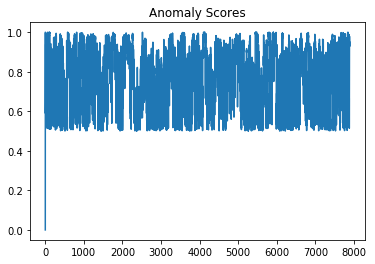

Time:  1.4732277393341064


['anomaly_scores/GLM/ambient_temperature_system_failure']

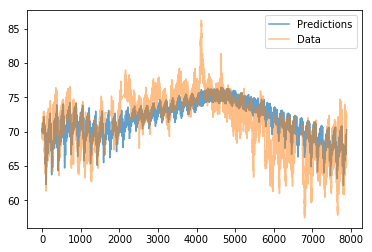

In [16]:
save_path = "anomaly_scores/GLM/" + dataset_name
output_dict = ad.glm(gaussian_window_size=gaussian_window_size, family='gaussian', 
                     eta=int(best_params[4:6]),
                     lambda_=float(best_params[14:]),
                     plot_anomaly_scores=True, plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)
